In [18]:
from utils import MLP, base_cost, get_episode, policy_objective, baseline_objective, sample_action, transform_action, systems, process_system, action_logprob, get_episode_cost
from jax import jit
from functools import partial
from tqdm.auto import tqdm
from datetime import timedelta as td, datetime as dt

import jax.numpy as jnp
import optax
import jax

def run_ac(
    system_info: dict,
    target: dict,
    **parameters: dict
):
    system_data = process_system(system_info)
    update = system_data["update"]

    state_dim = len(system_data["state_vars"])
    action_dim = len(system_data["action_vars"])
    system_params = jnp.array([system_info["params"][k] for k in system_data["params"]])

    policy_model = MLP(dims=[*parameters["policy_hidden_dims"], action_dim])
    policy_params = policy_model.init(parameters["policy_seed"], jnp.empty(state_dim))

    get_raw_action = jit(policy_model.apply)
    policy_opt = optax.adam(learning_rate=parameters["policy_lr"])
    policy_opt_state = policy_opt.init(policy_params)

    baseline_model = MLP(dims=[*parameters["baseline_hidden_dims"], 1])
    baseline_params = baseline_model.init(parameters["baseline_seed"], jnp.empty(state_dim))

    get_baseline = jit(baseline_model.apply)

    baseline_opt = optax.adam(learning_rate=parameters["baseline_lr"])
    baseline_opt_state = baseline_opt.init(baseline_params)

    var_idx = jnp.array([system_data["state_vars"].index(v) for v in target.keys()])
    var_targ = jnp.array(list(target.values()))
    cost = jit(partial(base_cost, i=var_idx, t=var_targ))

    action_transforms = tuple(system_info["actions"][act]["transform"] for act in system_data["action_vars"])
    action_postprocess = tuple(system_info["actions"][act]["postprocess"] for act in system_data["action_vars"])

    sigma = parameters["policy_sigma"]

    baseline_obj_and_grad = jax.value_and_grad(
        lambda params, states, tail_costs: baseline_objective(
            get_baseline(params, states).squeeze(),
            tail_costs
        )
    )

    policy_obj_and_grad = jax.value_and_grad(lambda params, states, actions, r: policy_objective(
        r, action_logprob(
            transform_action(
                get_raw_action(params, states),
                action_transforms
            ),
            actions,
            sigma
        )
    ))

    initial_state_stub = system_info["initial_state_stub"] if "initial_state_stub" in system_info else lambda x: x

    eval_states = initial_state_stub(jax.random.uniform(parameters["eval_seed"], (parameters["eval_n_episodes"], state_dim)))
    eval_costs = []

    key = parameters["seed"]
    n_steps = parameters["n_steps"]

    get_action = lambda params, state: transform_action(get_raw_action(params, state), action_transforms)
    action_sampler = lambda params, state, key: sample_action(get_action(params, state), sigma, key, action_postprocess)

    start_time = dt.now()
    last_eval_time = start_time

    eval_num = 0
    while dt.now() - start_time < parameters["train_time"]:
        key, seed = jax.random.split(key)
        initial_states = initial_state_stub(jax.random.uniform(key, (parameters["train_n_episodes"], state_dim)))

        key, seed = jax.random.split(key)
        states, actions = get_episode(update, system_params, action_sampler, policy_params, initial_states, n_steps, seed)

        tail_costs = jnp.cumsum(cost(states[:,1:])[:,::-1], axis=1)[:,::-1]
        states = states[:,:-1,:]

        r = tail_costs - get_baseline(baseline_params, states).squeeze()

        val, grad = baseline_obj_and_grad(baseline_params, states, tail_costs)
        updates, baseline_opt_state = baseline_opt.update(grad, baseline_opt_state)
        baseline_params = optax.apply_updates(baseline_params, updates)

        val, grad = policy_obj_and_grad(policy_params, states, actions, r)
        updates, policy_opt_state = policy_opt.update(grad, policy_opt_state)
        policy_params = optax.apply_updates(policy_params, updates)

        cur_time = dt.now()
        if cur_time - last_eval_time > parameters["eval_period"]:
            last_eval_time = cur_time
            eval_cost = get_episode_cost(policy_params, update, system_params, get_action, eval_states, cost, parameters["n_steps"], parameters["eval_seed"])
            print(f"{eval_num} {cur_time}: eval cost {eval_cost:.6f}")
            eval_costs.append(eval_cost)
            eval_num += 1

    cur_time = dt.now()
    last_eval_time = cur_time
    eval_cost = get_episode_cost(policy_params, update, system_params, get_action, eval_states, cost, parameters["n_steps"], parameters["eval_seed"])
    print(f"{cur_time}: eval cost {eval_cost:.6f}")
    eval_costs.append(eval_cost)

    return dict(policy_params=policy_params, eval_costs=eval_costs)

def run_pg(
    system_info: dict,
    target: dict,
    **parameters: dict
):
    system_data = process_system(system_info)
    update = system_data["update"]

    state_dim = len(system_data["state_vars"])
    action_dim = len(system_data["action_vars"])
    system_params = jnp.array([system_info["params"][k] for k in system_data["params"]])

    policy_model = MLP(dims=[*parameters["policy_hidden_dims"], action_dim])
    policy_params = policy_model.init(parameters["policy_seed"], jnp.empty(state_dim))

    get_raw_action = jit(policy_model.apply)
    policy_opt = optax.adam(learning_rate=parameters["policy_lr"])
    policy_opt_state = policy_opt.init(policy_params)

    var_idx = jnp.array([system_data["state_vars"].index(v) for v in target.keys()])
    var_targ = jnp.array(list(target.values()))
    cost = jit(partial(base_cost, i=var_idx, t=var_targ))

    action_transforms = tuple(system_info["actions"][act]["transform"] for act in system_data["action_vars"])
    action_postprocess = tuple(system_info["actions"][act]["postprocess"] for act in system_data["action_vars"])

    sigma = parameters["policy_sigma"]

    policy_obj_and_grad = jax.value_and_grad(lambda params, states, actions, r: policy_objective(
        r, action_logprob(
            transform_action(
                get_raw_action(params, states),
                action_transforms
            ),
            actions,
            sigma
        )
    ))

    initial_state_stub = system_info["initial_state_stub"] if "initial_state_stub" in system_info else lambda x: x

    eval_states = initial_state_stub(jax.random.uniform(parameters["eval_seed"], (parameters["eval_n_episodes"], state_dim)))
    eval_costs = []

    key = parameters["seed"]
    n_steps = parameters["n_steps"]

    get_action = lambda params, state: transform_action(get_raw_action(params, state), action_transforms)
    action_sampler = lambda params, state, key: sample_action(get_action(params, state), sigma, key, action_postprocess)

    start_time = dt.now()
    last_eval_time = start_time

    while dt.now() - start_time < parameters["train_time"]:
        key, seed = jax.random.split(key)
        initial_states = initial_state_stub(jax.random.uniform(key, (parameters["train_n_episodes"], state_dim)))

        key, seed = jax.random.split(key)
        states, actions = get_episode(update, system_params, action_sampler, policy_params, initial_states, n_steps, seed)

        tail_costs = jnp.cumsum(cost(states[:,1:])[:,::-1], axis=1)[:,::-1]
        states = states[:,:-1,:]

        r = tail_costs

        val, grad = policy_obj_and_grad(policy_params, states, actions, r)
        updates, policy_opt_state = policy_opt.update(grad, policy_opt_state)
        policy_params = optax.apply_updates(policy_params, updates)

        cur_time = dt.now()
        if cur_time - last_eval_time > parameters["eval_period"]:
            last_eval_time = cur_time
            eval_cost = get_episode_cost(policy_params, update, system_params, get_action, eval_states, cost, parameters["n_steps"], parameters["eval_seed"])
            print(f"{cur_time}: eval cost {eval_cost:.6f}")
            eval_costs.append(eval_cost)

    cur_time = dt.now()
    last_eval_time = cur_time
    eval_cost = get_episode_cost(policy_params, update, system_params, get_action, eval_states, cost, parameters["n_steps"], parameters["eval_seed"])
    print(f"{cur_time}: eval cost {eval_cost:.6f}")
    eval_costs.append(eval_cost)

    return dict(policy_params=policy_params, eval_costs=eval_costs)

def run_neural_mpc(
    system_info: dict,
    target: dict,
    **parameters: dict
):
    system_data = process_system(system_info)
    update = system_data["update"]

    state_dim = len(system_data["state_vars"])
    action_dim = len(system_data["action_vars"])
    system_params = jnp.array([system_info["params"][k] for k in system_data["params"]])

    policy_model = MLP(dims=[*parameters["policy_hidden_dims"], action_dim])
    policy_params = policy_model.init(parameters["policy_seed"], jnp.empty(state_dim))

    get_raw_action = jit(policy_model.apply)
    policy_opt = optax.adam(learning_rate=parameters["policy_lr"])
    policy_opt_state = policy_opt.init(policy_params)

    action_transforms = tuple(system_info["actions"][act]["transform"] for act in system_data["action_vars"])
    obj_val_and_grad = jax.value_and_grad(get_episode_cost)

    initial_state_stub = system_info["initial_state_stub"] if "initial_state_stub" in system_info else lambda x: x

    var_idx = jnp.array([system_data["state_vars"].index(v) for v in target.keys()])
    var_targ = jnp.array(list(target.values()))
    cost = jit(partial(base_cost, i=var_idx, t=var_targ))

    eval_costs = []
    eval_states = initial_state_stub(jax.random.uniform(parameters["eval_seed"], (parameters["eval_n_episodes"], state_dim)))

    key = parameters["seed"]
    n_steps = parameters["n_steps"]

    start_time = dt.now()
    last_eval_time = start_time

    get_action = lambda params, state: transform_action(get_raw_action(params, state), action_transforms)

    eval_num = 0
    while dt.now() - start_time < parameters["train_time"]:
        key, seed = jax.random.split(key)
        initial_states = initial_state_stub(jax.random.uniform(key, (parameters["train_n_episodes"], state_dim)))

        key, seed = jax.random.split(key)
        val, grad = obj_val_and_grad(policy_params, update, system_params, get_action, initial_states, cost, n_steps, seed)
        updates, policy_opt_state = policy_opt.update(grad, policy_opt_state)
        policy_params = optax.apply_updates(policy_params, updates)

        cur_time = dt.now()
        if cur_time - last_eval_time > parameters["eval_period"]:
            last_eval_time = cur_time
            eval_cost = get_episode_cost(policy_params, update, system_params, get_action, eval_states, cost, parameters["n_steps"], parameters["eval_seed"])
            print(f"{eval_num} {cur_time}: eval cost {eval_cost:.6f}")
            eval_costs.append(eval_cost)
            eval_num += 1

    cur_time = dt.now()
    last_eval_time = cur_time
    eval_cost = get_episode_cost(policy_params, update, system_params, get_action, eval_states, cost, parameters["n_steps"], parameters["eval_seed"])
    print(f"{cur_time}: eval cost {eval_cost:.6f}")
    eval_costs.append(eval_cost)

    return dict(policy_params=policy_params, eval_costs=eval_costs)

In [107]:
n_steps = 64
policy_sigma = 5e-2

seed = jnp.array([123, 123], dtype="u4")

eval_seed = jnp.array([101, 101], dtype="u4")
eval_n_episodes = 4096
eval_period = td(seconds=15)

train_time = td(minutes=15)
train_n_episodes = 2048

hidden_dims = [256]

lr = 1e-2

results = {}

for sys_name, target in [
    ("SIM", dict(YD=1.2, C=0.8)),
    ("SIMEX", dict(YD=1.2, C=0.8)),
    ("PC", dict(YD=1.2, C=0.8)),
    ("PCEX_deterministic", dict(YD=1.2, C=0.8)),
    ("PCEX_stochastic", dict(YD=1.2, C=0.8)),
    ("LP", dict(YD_r=1.2, C=0.8)),
    ("LP2", dict(YD_r=1.2, C=0.8)),
    ("REG", dict(YD_N=1.2, C_S=0.8)),
]:
    print()
    print(sys_name)
    print()

    print("mpc")
    mpc_res = run_neural_mpc(
        system_info=systems[sys_name],
        target=target,
        policy_hidden_dims=hidden_dims,
        policy_seed=seed,
        policy_lr=lr,
        seed=seed,
        n_steps=n_steps,
        eval_seed=eval_seed,
        train_n_episodes=train_n_episodes,
        train_time=train_time,
        eval_n_episodes=eval_n_episodes,
        eval_period=eval_period,
    )

    print("\nac")
    ac_res = run_ac(
        system_info=systems[sys_name],
        target=target,
        policy_hidden_dims=hidden_dims,
        policy_seed=seed,
        policy_lr=lr,
        baseline_hidden_dims=hidden_dims,
        baseline_seed=seed,
        baseline_lr=lr,
        policy_sigma=policy_sigma,
        seed=seed,
        n_steps=n_steps,
        eval_seed=eval_seed,
        train_n_episodes=train_n_episodes,
        train_time=train_time,
        eval_n_episodes=eval_n_episodes,
        eval_period=eval_period,
    )

    print("\npg")
    pg_res = run_pg(
        system_info=systems[sys_name],
        target=target,
        policy_hidden_dims=hidden_dims,
        policy_seed=seed,
        policy_lr=lr,
        policy_sigma=policy_sigma,
        seed=seed,
        n_steps=n_steps,
        eval_seed=eval_seed,
        train_n_episodes=train_n_episodes,
        train_time=train_time,
        eval_n_episodes=eval_n_episodes,
        eval_period=eval_period,
    )

    results[sys_name] = dict(ac=ac_res, mpc=mpc_res, pg=pg_res)


SIM

mpc
2024-06-04 23:04:23.058492: eval cost 0.399657
2024-06-04 23:04:38.161265: eval cost 0.373018
2024-06-04 23:04:53.210212: eval cost 0.318876
2024-06-04 23:05:08.714831: eval cost 0.215233
2024-06-04 23:05:23.867690: eval cost 0.124065
2024-06-04 23:05:39.042745: eval cost 0.105217
2024-06-04 23:05:54.379859: eval cost 0.101161
2024-06-04 23:06:09.676700: eval cost 0.097032
2024-06-04 23:06:24.863447: eval cost 0.093422
2024-06-04 23:06:39.948290: eval cost 0.090617
2024-06-04 23:06:55.238460: eval cost 0.088330
2024-06-04 23:07:10.300673: eval cost 0.086529
2024-06-04 23:07:25.300961: eval cost 0.085125
2024-06-04 23:07:40.511626: eval cost 0.084043
2024-06-04 23:07:55.646049: eval cost 0.083212
2024-06-04 23:08:10.759749: eval cost 0.082614
2024-06-04 23:08:26.100553: eval cost 0.082159
2024-06-04 23:08:41.289710: eval cost 0.081812
2024-06-04 23:08:56.347576: eval cost 0.081532
2024-06-04 23:09:11.544353: eval cost 0.081312
2024-06-04 23:09:26.909510: eval cost 0.081145
202

In [113]:
import matplotlib.pyplot as plt

In [114]:
system_list = [
    ["SIM", "SIMEX"],
    ["PC", "PCEX_deterministic", "PCEX_stochastic"],
    ["LP", "LP2"],
    ["REG"],
]

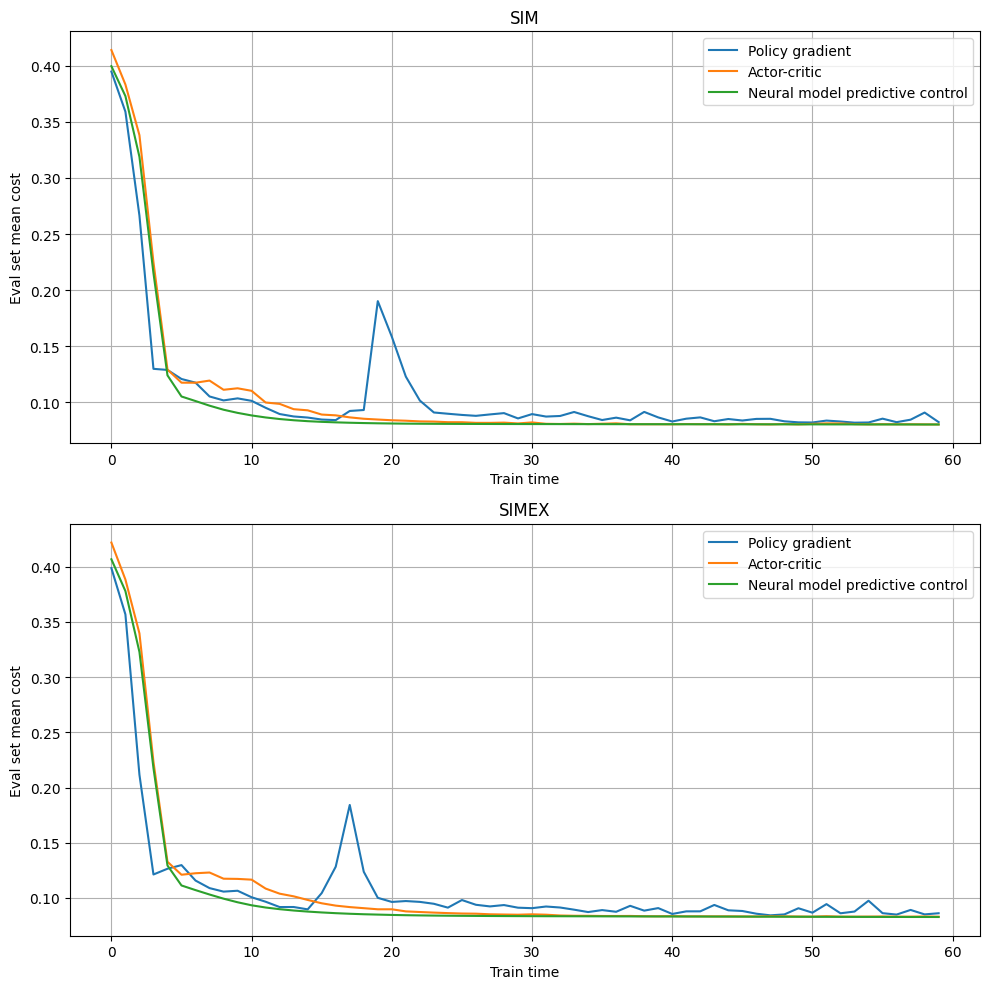

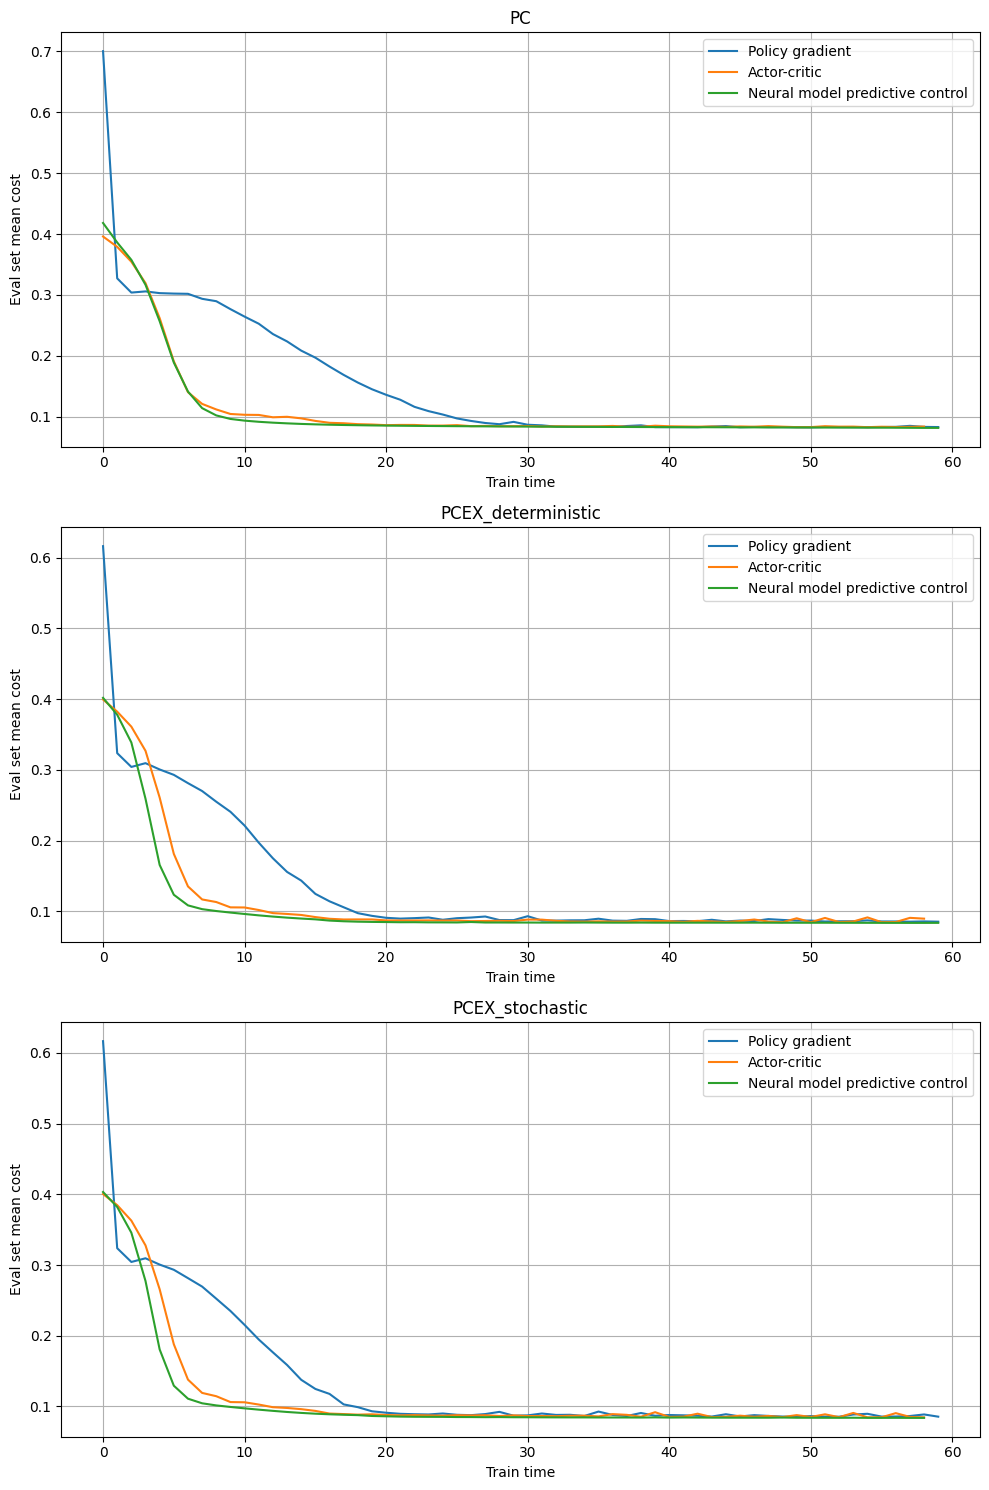

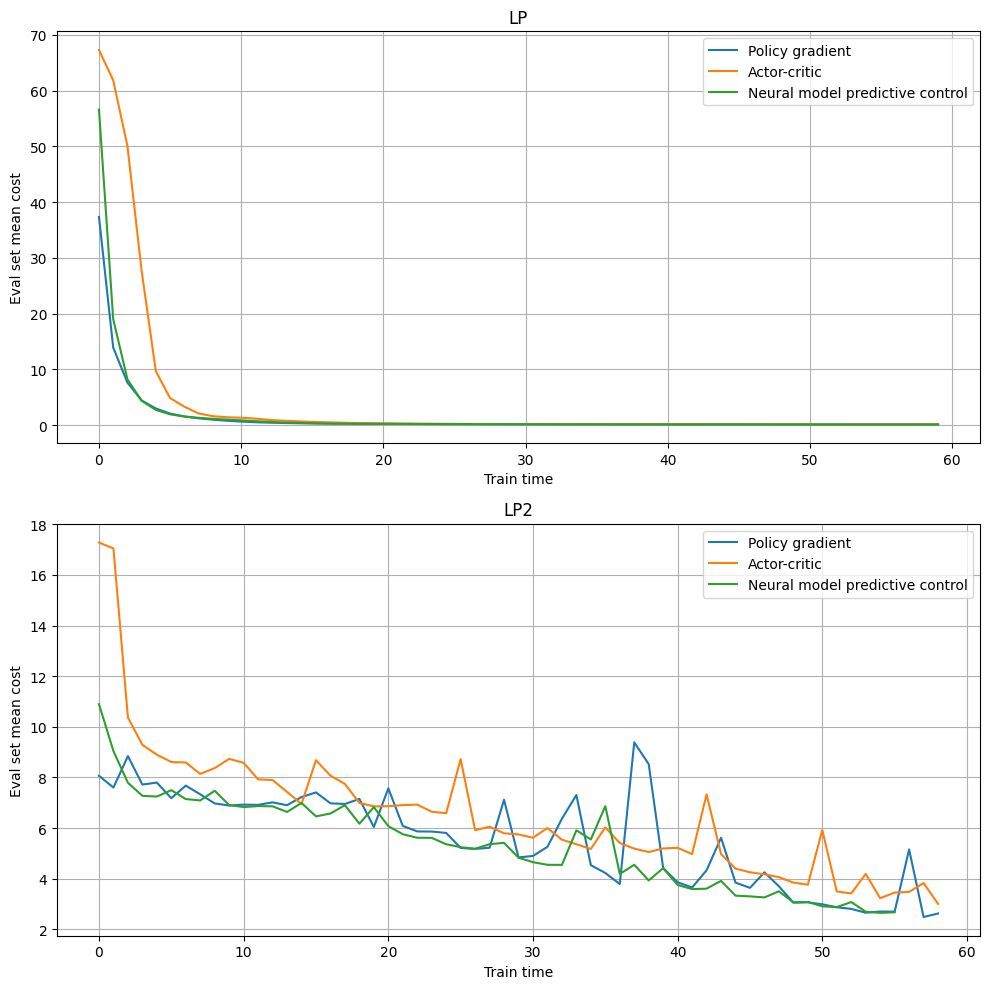

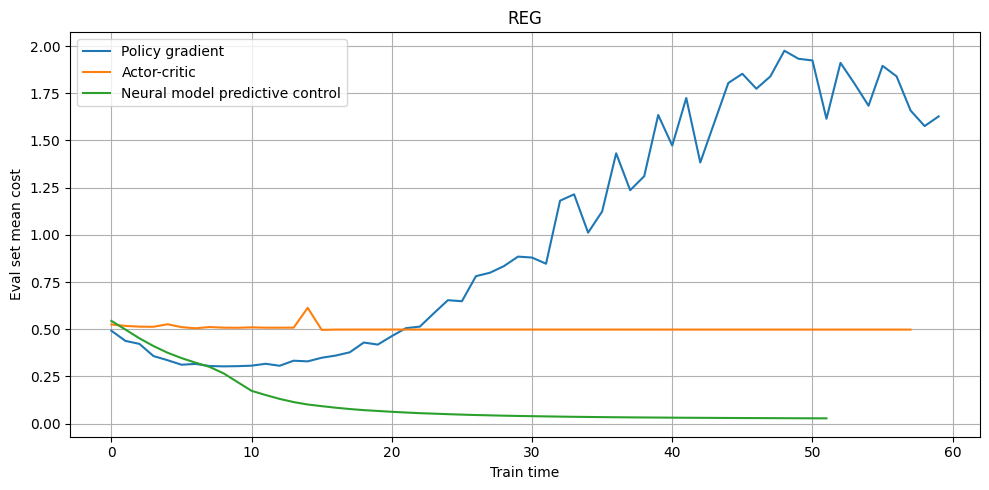

In [115]:
for sys_subset in system_list:
    nrows = len(sys_subset)
    fig, ax = plt.subplots(nrows=nrows, figsize=(10, 5 * nrows), tight_layout=True)
    if nrows == 1:
        ax = [ax]

    for i, sys_name in enumerate(sys_subset):
        ax[i].set_title(sys_name)
        ax[i].plot(results[sys_name]["pg"]["eval_costs"], label="Policy gradient")
        ax[i].plot(results[sys_name]["ac"]["eval_costs"], label="Actor-critic")
        ax[i].plot(results[sys_name]["mpc"]["eval_costs"], label="Neural model predictive control")
        ax[i].grid()
        ax[i].set_ylabel("Eval set mean cost")
        ax[i].set_xlabel("Train time")
        ax[i].legend()

    fig.savefig(f"{'_'.join(sys_subset)}_bench.png")

In [111]:
import pandas as pd

In [112]:
print(pd.DataFrame({sys_name: {k: float(min(results[sys_name][k]["eval_costs"])) for k in results[sys_name]} for sys_name in systems}).T[["pg", "ac", "mpc"]].rename(columns={
    "pg": "Policy gradient",
    "ac": "Actor-critic",
    "mpc": "Neural MPC"
}).to_latex())

\begin{tabular}{lrrr}
\toprule
{} &  Policy gradient &        ac &       mpc \\
\midrule
SIM                &         0.081877 &  0.080298 &  0.080250 \\
SIMEX              &         0.084289 &  0.083075 &  0.082789 \\
PC                 &         0.082201 &  0.082539 &  0.081349 \\
PCEX\_deterministic &         0.085339 &  0.084551 &  0.083634 \\
PCEX\_stochastic    &         0.085456 &  0.084559 &  0.083812 \\
LP                 &         0.114625 &  0.127741 &  0.113243 \\
LP2                &         2.491034 &  3.010130 &  2.655055 \\
REG                &         0.303549 &  0.496719 &  0.028288 \\
\bottomrule
\end{tabular}



/var/folders/80/y_10x_2933s00yx1tc7tlrhc0000gn/T/ipykernel_37248/1104178764.py:5: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  }).to_latex())


In [ ]:
results[sys_name]["pg"]

In [80]:
n_steps = 64
policy_sigma = 5e-2

seed = jnp.array([123, 123], dtype="u4")

eval_seed = jnp.array([101, 101], dtype="u4")
eval_n_episodes = 256
eval_period = td(seconds=5)

train_time = td(minutes=30)
train_n_episodes = 256

hidden_dims = [256]

lr = 1e-2

sys_name = "LP"
target = dict(YD_r=1.2, C=0.8)

In [81]:
mpc_res = run_neural_mpc(
    system_info=systems[sys_name],
    target=target,
    policy_hidden_dims=hidden_dims,
    policy_seed=seed,
    policy_lr=lr,
    seed=seed,
    n_steps=n_steps,
    eval_seed=eval_seed,
    train_n_episodes=train_n_episodes,
    train_time=train_time,
    eval_n_episodes=eval_n_episodes,
    eval_period=eval_period,
)

0 2024-06-05 19:24:50.243641: eval cost 69.349106
1 2024-06-05 19:24:55.446000: eval cost 48.702652
2 2024-06-05 19:25:00.566867: eval cost 24.351135
3 2024-06-05 19:25:05.696636: eval cost 13.491800
4 2024-06-05 19:25:10.841454: eval cost 8.329907
5 2024-06-05 19:25:15.979371: eval cost 5.517478
6 2024-06-05 19:25:21.145554: eval cost 3.871563
7 2024-06-05 19:25:26.297846: eval cost 2.875575
8 2024-06-05 19:25:31.441754: eval cost 2.266778
9 2024-06-05 19:25:36.582524: eval cost 1.878740
10 2024-06-05 19:25:41.712476: eval cost 1.623385
11 2024-06-05 19:25:46.847710: eval cost 1.451263
12 2024-06-05 19:25:52.004072: eval cost 1.327204
13 2024-06-05 19:25:57.156534: eval cost 1.225254
14 2024-06-05 19:26:02.488886: eval cost 1.131861
15 2024-06-05 19:26:07.629792: eval cost 1.042352
16 2024-06-05 19:26:12.769848: eval cost 0.953858
17 2024-06-05 19:26:17.912024: eval cost 0.867856
18 2024-06-05 19:26:23.071793: eval cost 0.783056
19 2024-06-05 19:26:28.223632: eval cost 0.699594
20 202

In [82]:
ac_res = run_ac(
    system_info=systems[sys_name],
    target=target,
    policy_hidden_dims=hidden_dims,
    policy_seed=seed,
    policy_lr=lr,
    baseline_hidden_dims=hidden_dims,
    baseline_seed=seed,
    baseline_lr=lr,
    policy_sigma=policy_sigma,
    seed=seed,
    n_steps=n_steps,
    eval_seed=eval_seed,
    train_n_episodes=train_n_episodes,
    train_time=train_time,
    eval_n_episodes=eval_n_episodes,
    eval_period=eval_period,
)

0 2024-06-05 20:01:43.601001: eval cost 68.375626
1 2024-06-05 20:01:48.611931: eval cost 50.776596
2 2024-06-05 20:01:53.614812: eval cost 19.656017
3 2024-06-05 20:01:58.669631: eval cost 8.225922
4 2024-06-05 20:02:03.670765: eval cost 3.531650
5 2024-06-05 20:02:08.730753: eval cost 1.871635
6 2024-06-05 20:02:13.778960: eval cost 1.236521
7 2024-06-05 20:02:18.845463: eval cost 0.851145
8 2024-06-05 20:02:23.891665: eval cost 0.577883
9 2024-06-05 20:02:28.930443: eval cost 0.403214
10 2024-06-05 20:02:33.945301: eval cost 0.316575
11 2024-06-05 20:02:39.000023: eval cost 0.253049
12 2024-06-05 20:02:44.043183: eval cost 0.229197
13 2024-06-05 20:02:49.050866: eval cost 0.213024
14 2024-06-05 20:02:54.080757: eval cost 0.202376
15 2024-06-05 20:02:59.082543: eval cost 0.192215
16 2024-06-05 20:03:04.085781: eval cost 0.182175
17 2024-06-05 20:03:09.143331: eval cost 0.173492
18 2024-06-05 20:03:14.199270: eval cost 0.166339
19 2024-06-05 20:03:19.201602: eval cost 0.159042
20 2024

In [75]:
system_info = systems[sys_name]
system_data = process_system(system_info)
update = system_data["update"]

state_dim = len(system_data["state_vars"])
action_dim = len(system_data["action_vars"])
system_params = jnp.array([system_info["params"][k] for k in system_data["params"]])

initial_state_stub = system_info["initial_state_stub"] if "initial_state_stub" in system_info else lambda x: x

policy_model = MLP(dims=[*hidden_dims, action_dim])

get_raw_action = jit(policy_model.apply)

action_transforms = tuple(system_info["actions"][act]["transform"] for act in system_data["action_vars"])
action_postprocess = tuple(system_info["actions"][act]["postprocess"] for act in system_data["action_vars"])

cost = jit(partial(base_cost, i=var_idx, t=var_targ))

In [76]:
var_idx = jnp.array([system_data["state_vars"].index(v) for v in target.keys()])
var_targ = jnp.array(list(target.values()))

In [77]:
key = seed

In [78]:
seed, key = jax.random.split(key)

get_action = lambda params, state: transform_action(get_raw_action(params, state), action_transforms)
action_sampler = lambda params, state, key: sample_action(get_action(params, state), 0, seed, action_postprocess)

initial_states = initial_state_stub(jax.random.uniform(seed, (1, state_dim)))
states, actions = get_episode(update, system_params, action_sampler, mpc_res["policy_params"], initial_states, n_steps, seed)

In [79]:
states[..., var_idx]

Array([[[0.8607888 , 0.0140084 ],
        [1.6532451 , 0.19112757],
        [1.1025783 , 1.3331174 ],
        [1.1674435 , 1.2013184 ],
        [1.1210885 , 1.2121346 ],
        [1.1068391 , 1.1934124 ],
        [1.0974078 , 1.1818446 ],
        [1.0894766 , 1.1713898 ],
        [1.0821155 , 1.1615083 ],
        [1.0753269 , 1.1519997 ],
        [1.0688336 , 1.1428838 ],
        [1.0625775 , 1.1340933 ],
        [1.0565388 , 1.1256074 ],
        [1.0507064 , 1.117413  ],
        [1.045073  , 1.1094997 ],
        [1.0396314 , 1.1018572 ],
        [1.034375  , 1.0944762 ],
        [1.0303725 , 1.0873475 ],
        [1.029132  , 1.0807849 ],
        [1.028981  , 1.0753102 ],
        [1.0291704 , 1.0705916 ],
        [1.02942   , 1.0664388 ],
        [1.0296571 , 1.0627441 ],
        [1.0298669 , 1.0594451 ],
        [1.0300498 , 1.0564955 ],
        [1.0302091 , 1.0538574 ],
        [1.0303482 , 1.0514979 ],
        [1.0304699 , 1.0493869 ],
        [1.0305766 , 1.0474983 ],
        [1.030

In [66]:
((states[..., var_idx][0,:,0] - 1.2) ** 2 + (states[..., var_idx][0,:,1] - 0.8) ** 2).mean()

Array(0.10941244, dtype=float32)

In [ ]:
# run_ac(
#     system_info=systems["LP"],
#     target=dict(YD_r=1.2, C=0.8),
#     policy_hidden_dims=[256],
#     policy_seed=jnp.array([123, 123], dtype="u4"),
#     policy_lr=5e-3,
#     baseline_hidden_dims=[256],
#     baseline_seed=jnp.array([123, 123], dtype="u4"),
#     baseline_lr=5e-2,
#     policy_sigma=1e-2,
#     n_epochs=512,
#     seed=jnp.array([123, 123], dtype="u4"),
#     n_steps=64,
#     eval_seed=jnp.array([101, 101], dtype="u4"),
#     eval_n_episodes=256,
#     eval_freq=32,
#     train_n_episodes=1024,
# )

In [ ]:
# run_ac(
#     system_info=systems["PCEX_stochastic"],
#     target=dict(YD=1.2, C=0.8),
#     policy_hidden_dims=[256],
#     policy_seed=jnp.array([123, 123], dtype="u4"),
#     policy_lr=5e-3,
#     baseline_hidden_dims=[256],
#     baseline_seed=jnp.array([123, 123], dtype="u4"),
#     baseline_lr=5e-2,
#     policy_sigma=1e-2,
#     n_epochs=512,
#     seed=jnp.array([123, 123], dtype="u4"),
#     n_steps=64,
#     eval_seed=jnp.array([101, 101], dtype="u4"),
#     eval_n_episodes=256,
#     eval_freq=32,
#     train_n_episodes=32,
# )

In [ ]:
# run_ac(
#     system_info=systems["PCEX_deterministic"],
#     target=dict(YD=1.2, C=0.8),
#     policy_hidden_dims=[256],
#     policy_seed=jnp.array([123, 123], dtype="u4"),
#     policy_lr=5e-3,
#     baseline_hidden_dims=[256],
#     baseline_seed=jnp.array([123, 123], dtype="u4"),
#     baseline_lr=5e-2,
#     policy_sigma=1e-2,
#     n_epochs=512,
#     seed=jnp.array([123, 123], dtype="u4"),
#     n_steps=64,
#     eval_seed=jnp.array([101, 101], dtype="u4"),
#     eval_n_episodes=256,
#     eval_freq=32,
#     train_n_episodes=32,
# )

In [ ]:
# run_ac(
#     system_info=systems["PC"],
#     target=dict(YD=1.2, C=0.8),
#     policy_hidden_dims=[256],
#     policy_seed=jnp.array([123, 123], dtype="u4"),
#     policy_lr=5e-3,
#     baseline_hidden_dims=[256],
#     baseline_seed=jnp.array([123, 123], dtype="u4"),
#     baseline_lr=5e-2,
#     policy_sigma=1e-2,
#     n_epochs=512,
#     seed=jnp.array([123, 123], dtype="u4"),
#     n_steps=64,
#     eval_seed=jnp.array([101, 101], dtype="u4"),
#     eval_n_episodes=256,
#     eval_freq=32,
#     train_n_episodes=32,
# )

In [ ]:
# run_ac(
#     system_info=systems["SIMEX"],
#     target=dict(YD=1.2, C=0.8),
#     policy_hidden_dims=[256],
#     policy_seed=jnp.array([123, 123], dtype="u4"),
#     policy_lr=5e-3,
#     baseline_hidden_dims=[256],
#     baseline_seed=jnp.array([123, 123], dtype="u4"),
#     baseline_lr=5e-2,
#     policy_sigma=1e-2,
#     n_epochs=512,
#     seed=jnp.array([123, 123], dtype="u4"),
#     n_steps=64,
#     eval_seed=jnp.array([101, 101], dtype="u4"),
#     eval_n_episodes=256,
#     eval_freq=32,
#     train_n_episodes=32,
# )

In [ ]:
# run_ac(
#     system_info=systems["SIM"],
#     target=dict(YD=1.2, C=0.8),
#     policy_hidden_dims=[256],
#     policy_seed=jnp.array([123, 123], dtype="u4"),
#     policy_lr=5e-3,
#     baseline_hidden_dims=[256],
#     baseline_seed=jnp.array([123, 123], dtype="u4"),
#     baseline_lr=5e-2,
#     policy_sigma=1e-2,
#     n_epochs=512,
#     seed=jnp.array([123, 123], dtype="u4"),
#     n_steps=64,
#     eval_seed=jnp.array([101, 101], dtype="u4"),
#     eval_n_episodes=256,
#     eval_freq=32,
#     train_n_episodes=32,
# )

In [37]:
seed = jnp.array([123,123], "u4")

system_info = systems["SIM"]
system_data = process_system(system_info)
update = system_data["update"]

state_dim = len(system_data["state_vars"])
action_dim = len(system_data["action_vars"])
system_params = jnp.array([system_info["params"][k] for k in system_data["params"]])

get_action = jit(lambda a,b: jnp.array([0.1, 0.1]))

In [38]:
state = jax.random.uniform(seed, (256, state_dim))

In [62]:
from typing import Callable

@partial(jit, static_argnames=["update", "action", "n_steps"])
def get_episode_new(update: Callable, system_params: jnp.ndarray, action: Callable, initial_state: jnp.ndarray, n_steps: int, seed: jnp.ndarray):
    state = initial_state
    states, actions = [initial_state], []

    for i in range(n_steps):
        key, seed = jax.random.split(seed)
        act = action(state, seed)
        actions.append(act)

        key, seed = jax.random.split(key)
        state = update(state, act, system_params, seed)
        states.append(state)

    return jnp.stack(states, axis=1), jnp.stack(actions, axis=1)

In [59]:
%%timeit
states, acts = get_episode(update, system_params, get_action, state, 64, seed)

9.14 ms ± 44.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [64]:
%%timeit
states, acts = get_episode_new(update, system_params, get_action, state, 64, seed)

1.28 ms ± 22.7 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [52]:
system_params

Array([0.05, 0.2 , 0.1 ], dtype=float32)

In [92]:
system_info=systems["LP"]
target=dict(YD_r=1.2, C=0.8)

In [93]:
parameters = dict(
    policy_hidden_dims=[256],
    policy_seed=jnp.array([123, 123], dtype="u4"),
    policy_lr=5e-3,
    baseline_hidden_dims=[256],
    baseline_seed=jnp.array([123, 123], dtype="u4"),
    baseline_lr=5e-2,
    policy_sigma=1e-2,
    n_epochs=512,
    seed=jnp.array([123, 123], dtype="u4"),
    n_steps=64,
    eval_seed=jnp.array([101, 101], dtype="u4"),
    eval_n_episodes=256,
    eval_freq=32,
    train_n_episodes=1024,
)

In [94]:
system_data = process_system(system_info)
update = system_data["update"]

state_dim = len(system_data["state_vars"])
action_dim = len(system_data["action_vars"])
system_params = jnp.array([system_info["params"][k] for k in system_data["params"]])

In [ ]:
policy_model = MLP(dims=[*parameters["policy_hidden_dims"], action_dim])
policy_params = policy_model.init(parameters["policy_seed"], jnp.empty(state_dim))

get_raw_action = jit(policy_model.apply)
policy_opt = optax.adam(learning_rate=parameters["policy_lr"])
policy_opt_state = policy_opt.init(policy_params)

baseline_model = MLP(dims=[*parameters["baseline_hidden_dims"], 1])
baseline_params = baseline_model.init(parameters["baseline_seed"], jnp.empty(state_dim))

get_baseline = jit(baseline_model.apply)

baseline_opt = optax.adam(learning_rate=parameters["baseline_lr"])
baseline_opt_state = baseline_opt.init(baseline_params)

var_idx = jnp.array([system_data["state_vars"].index(v) for v in target.keys()])
var_targ = jnp.array(list(target.values()))
cost = jit(partial(base_cost, i=var_idx, t=var_targ))

action_transforms = tuple(system_info["actions"][act]["transform"] for act in system_data["action_vars"])
action_postprocess = tuple(system_info["actions"][act]["postprocess"] for act in system_data["action_vars"])

sigma = parameters["policy_sigma"]

baseline_obj_and_grad = jax.value_and_grad(
    lambda params, states, tail_costs: baseline_objective(
        get_baseline(params, states).squeeze(),
        tail_costs
    )
)

policy_obj_and_grad = jax.value_and_grad(lambda params, states, actions, r: policy_objective(
    r, action_logprob(
        transform_action(
            get_raw_action(params, states),
            action_transforms
        ),
        actions,
        sigma
    )
))

In [ ]:
eval_states = initial_state_stub(jax.random.uniform(parameters["eval_seed"], (parameters["eval_n_episodes"], state_dim)))
eval_costs = []

key = parameters["seed"]
n_steps = parameters["n_steps"]

get_action = lambda params, state: transform_action(get_raw_action(params, state), action_transforms)
action_sampler = lambda params, state, key: sample_action(get_action(params, state), sigma, key, action_postprocess)

start_time = dt.now()
last_eval_time = start_time

eval_num = 0
while dt.now() - start_time < parameters["train_time"]:
    key, seed = jax.random.split(key)
    initial_states = initial_state_stub(jax.random.uniform(key, (parameters["train_n_episodes"], state_dim)))

    key, seed = jax.random.split(key)
    states, actions = get_episode(update, system_params, action_sampler, policy_params, initial_states, n_steps, seed)

    tail_costs = jnp.cumsum(cost(states[:,1:])[:,::-1], axis=1)[:,::-1]
    states = states[:,:-1,:]

    r = tail_costs - get_baseline(baseline_params, states).squeeze()

    val, grad = baseline_obj_and_grad(baseline_params, states, tail_costs)
    updates, baseline_opt_state = baseline_opt.update(grad, baseline_opt_state)
    baseline_params = optax.apply_updates(baseline_params, updates)

    val, grad = policy_obj_and_grad(policy_params, states, actions, r)
    updates, policy_opt_state = policy_opt.update(grad, policy_opt_state)
    policy_params = optax.apply_updates(policy_params, updates)

    cur_time = dt.now()
    if cur_time - last_eval_time > parameters["eval_period"]:
        last_eval_time = cur_time
        eval_cost = get_episode_cost(policy_params, update, system_params, get_action, eval_states, cost, parameters["n_steps"], parameters["eval_seed"])
        print(f"{eval_num} {cur_time}: eval cost {eval_cost:.6f}")
        eval_costs.append(eval_cost)
        eval_num += 1

cur_time = dt.now()
last_eval_time = cur_time
eval_cost = get_episode_cost(policy_params, update, system_params, get_action, eval_states, cost, parameters["n_steps"], parameters["eval_seed"])
print(f"{cur_time}: eval cost {eval_cost:.6f}")
eval_costs.append(eval_cost)

return dict(policy_params=policy_params, eval_costs=eval_costs)
